# Programming Assignment 2 Coding part: Neural Networks and Transformer

### Instructor: Yuanyuan Shi

### Teaching Assistants

- Yuexin Bian, [yubian@ucsd.edu]
- Luke Bhan[lbhan@ucsd.edu]
- Rich Pai, [cpai@ucsd.edu]
-Zekai Zhao, [zez020@ucsd.edu]

## Instructions
1. This assignment must be completed individually.  
2. This notebook contains skeleton code, which should not be modified
3. You must run all cells in this notebook and submit this notebook as an .ipynb file.
4. You must submit the .ipynb on Gradescope. You must mark each problem on Gradescope in the pdf.

## Setup

In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader, random_split, TensorDataset
import time
# Comment it if you are not using mac
%config InlineBackend.figure_format = 'retina'

# The following cell helps you evaluate gradients in Written Homework Q1.4

In [5]:
def get_pred(W, x, b, v, c):
    relu = torch.nn.ReLU()
    # TODO: Write out the analytical solution of h
    h = relu(x @ W.T + b.T)
    # TODO: Write out the analytical solution of h
    yhat = h @ v + c
    return yhat


def update_parameters(W, b, v, c, lr=0.1):   
    # TODO: Write out the update parameters using param.grad
    W = W - lr * W.grad
    b = b - lr * b.grad
    v = v - lr * v.grad
    c = c - lr * c.grad
    return W, b, v, c


x = torch.tensor([[1, 0, 2]], dtype=torch.float32, requires_grad=True)
y = torch.tensor([[3]], dtype=torch.float32, requires_grad=True)
W = torch.tensor([[1, -1, 0], [0, 2, 1]], dtype=torch.float32, requires_grad=True)
b = torch.tensor([[0], [1]], dtype=torch.float32, requires_grad=True)
v = torch.tensor([[2], [-1]], dtype=torch.float32, requires_grad=True)
c = torch.tensor([[0.]], dtype=torch.float32, requires_grad=True)
y = 3


yhat = get_pred(W, x, b, v, c)
L = 1/2 * (yhat - y) ** 2 
print(f"Current prediction = {yhat}, L = {L}")
L.backward()
print("W.grad", W.grad)
print("b.grad", b.grad)
print("v.grad", v.grad)
print("c.grad", c.grad)
W, b, v, c = update_parameters(W, b, v, c, lr=0.02)
yhat = get_pred(W, x, b, v, c)
L = 1/2 * (yhat - y) ** 2 
print()
print("*" * 100)
print(f"Current prediction = {yhat}, L = {L}")

Current prediction = tensor([[-1.]], grad_fn=<AddBackward0>), L = tensor([[8.]], grad_fn=<MulBackward0>)
W.grad tensor([[ -8.,  -0., -16.],
        [  4.,   0.,   8.]])
b.grad tensor([[-8.],
        [ 4.]])
v.grad tensor([[ -4.],
        [-12.]])
c.grad tensor([[-4.]])

****************************************************************************************************
Current prediction = tensor([[2.2416]], grad_fn=<AddBackward0>), L = tensor([[0.2876]], grad_fn=<MulBackward0>)


# Visualize the data

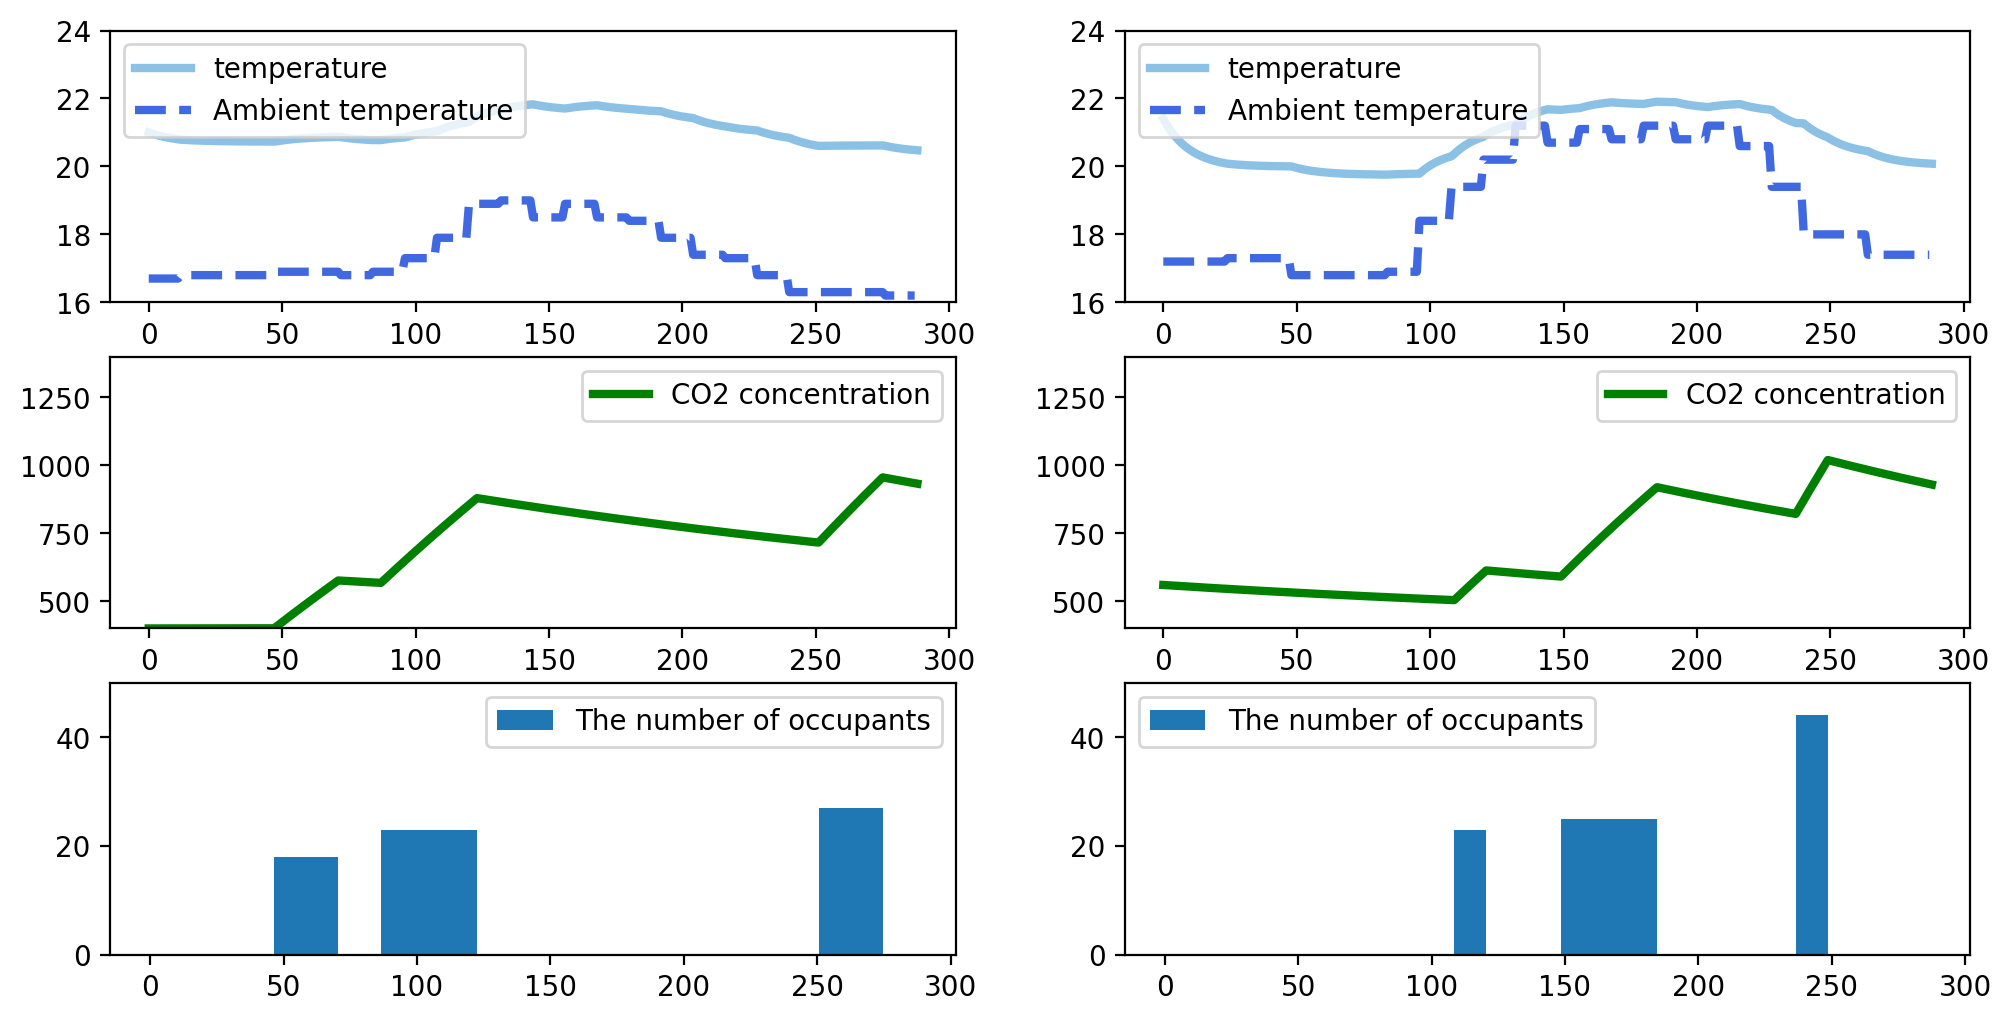

In [7]:
def plot(data):
    fig, ax = plt.subplots(3,2, figsize=(12, 6))
    temp = data['temp']
    co2 = data['co2']
    people = data['d']
    u1 = data['u1']
    u2 = data['u2']
    amb = data['amb']
    show = [0,10]
    for idx in range(2):
        ax[0][idx].plot(temp[show[idx]], label='temperature', color='#8cc1e6', linewidth=3)
        ax[0][idx].plot(amb[show[idx]], label='Ambient temperature', linestyle='--', color='#4069e1', linewidth=3)
        ax[1][idx].plot(co2[show[idx]], label='CO2 concentration',  color='green', linewidth=3)
        ax[2][idx].bar(list(range(288)), people[show[idx]], width=1.0, label='The number of occupants')
        ax[1][idx].set_ylim([400, 1400])
        ax[2][idx].set_ylim([0, 50])
        ax[0][idx].set_ylim([16,24])
    for i in range(3):
        for idx in range(2):
            ax[i][idx].legend()
    plt.savefig('data.png', dpi=300)
    plt.show()

data = np.load('simulation_data_hw2.npz')


plot(data)

## Part1. MLP models for prediction (10 points)

### Task 1.1 Implement MLP (2 points)

In [9]:
import torch
import torch.nn as nn

class MLPModel(nn.Module):
    """
    A simple MLP-based predictor that flattens the entire input sequence.
    """
    def __init__(self, input_dim: int, seq_len: int, hidden_dim: int, output_dim: int):
        """
        - input_dim:   feature dimension at each time step
        - seq_len:     number of time steps in the sequence
        - hidden_dim:  width of the hidden MLP layer
        - output_dim:  dimension of the prediction
        """
        super(MLPModel, self).__init__()
        # TODO: Initialize a flatten layer, an input_layer, an outputlayer and an activation layer
        self.flatten = nn.Flatten() # Initialize a flatten layer
        self.input_layer = nn.Linear(seq_len * input_dim, hidden_dim) # input_layer
        self.activation = nn.ReLU() # activation layer
        self.output_layer = nn.Linear(hidden_dim, output_dim) # output layer


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [batch_size, seq_len, input_dim]
        returns y: [batch_size, output_dim]
        """
        # TODO: process your input
        x_flat = self.flatten(x)  
        x_input = self.input_layer(x_flat) 
        hidden = self.activation(x_input) # [batch_size, hidden_dim]
        y = self.output_layer(hidden)
        return y

In [10]:
# Let's run a sanity check of your model
input_dim = 6
seq_len = 24
hidden_dim = 16
output_dim = 2
batch_size = 2
x = torch.randn((batch_size, seq_len, input_dim))
model = MLPModel(input_dim, seq_len, hidden_dim, output_dim)
y = model(x)
assert y.shape == (batch_size, output_dim)
print(y.shape)

torch.Size([2, 2])


### Task 1.2 Implement Training function and Evaluation function (3 points)

In [12]:
import time

def train(model, optimizer, dataloader, loss_func, device):
    model.train()
    total_mse, total_count = 0, 0

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        y_pred = None
        ###########################################################################
        # TODO: compute the prediction of the input, get the loss, and do the     #
        # gradient backpropagation.
        ###########################################################################
        y_pred = model(X)
        loss = loss_func(y_pred, y)
        loss.backward()

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        optimizer.step()
        total_mse += loss.item()
        total_count += X.size(0)
    return total_mse / total_count
        

def evaluate(model, dataloader, loss_func, device, normalize=True):
    model.eval()
    total_mse, total_count = 0, 0

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            ###########################################################################
            # TODO: compute the prediction of the input, get the loss.                #
            # If normlize the data, multiply the prediction value and true value by its range, please see task 1.5 how we normalize the data
            ###########################################################################
            y_pred = model(X)
            if normalize:
                denorm = torch.tensor([30.0, 2000.0], device=device)
                y_pred = y_pred * denorm
                y = y * denorm
            loss = loss_func(y_pred, y)
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################

            total_mse += loss.item()
            total_count += X.size(0)
    return total_mse/total_count

### Prepare the dataset

In [14]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor
Tensor = FloatTensor

def createSamples(data, lookBack, normalize=False):
    dataX = []
    dataY = []
    temp, co2, people, u1, u2, amb = data['temp'], data['co2'], data['d'], data['u1'], data['u2'], data['amb']
    if normalize:
        # Note: Divide variable of its range
        temp /= 30
        co2 /= 2000
        people /= 100
        u1 /= 30
        u2 /= 20
        amb /= 30
    B, T = temp.shape
    u1 = np.repeat(u1, T, axis=1)
    u2 = np.repeat(u2, T, axis=1)
    for t in range(T-lookBack):
        x = np.stack([temp[:,t:t+lookBack], co2[:,t:t+lookBack], people[:,t:t+lookBack], u1[:,t:t+lookBack], u2[:,t:t+lookBack], amb[:,t:t+lookBack]], axis=-1)
        y = np.concatenate([temp[:,t+lookBack:t+lookBack+1], co2[:,t+lookBack:t+lookBack+1]], axis=1)
        dataX.append(x)
        dataY.append(y)
    X = np.concatenate(dataX, axis=0)
    Y = np.concatenate(dataY, axis=0)
    return Tensor(X), Tensor(Y)

### Task 1.3 Conduct experiments (5 points)

In [16]:
# Hyper parameters
batch_size  = 64
epochs      = 100
lr          = 1e-4
mlp_hidden  = 128   # whatever hidden size you like

###########################################################################
# 1) Load & preprocess your data first, so you know seq_len & dims
###########################################################################
# Change normalize bool variable to get raw data or normalized data
X, y = createSamples(data, lookBack=24, normalize=True)
print("X.shape", X.shape)
print("y.shape", y.shape)

# infer dims from the tensors
_, seq_len, input_dim = X.shape
_, output_dim        = y.shape

# now wrap into a dataset / dataloader
dataset            = TensorDataset(X, y)
train_size         = int(0.8 * len(dataset))
val_size           = int(0.1 * len(dataset))
test_size          = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

###########################################################################
# 2) Define your MLP-based model and loss
###########################################################################

#TODO: Initialized your model
model = MLPModel(input_dim=input_dim, seq_len=seq_len,
                 hidden_dim=mlp_hidden, output_dim=output_dim).to(device)

#TODO: Initialized your loss function (MSE Loss)
loss_func = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)


###########################################################################
# 3) Training loop (unchanged)
###########################################################################
total_mse = None
train_mse_lst = []
val_mse_lst = []
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    mse_train = train(model, optimizer, train_loader, loss_func, device)
    mse_val = evaluate(model, val_loader, loss_func, device)
    train_mse_lst += [mse_train]
    val_mse_lst += [mse_val]
    if total_mse is not None and total_mse > mse_val:
        scheduler.step()
    else:
        total_mse = mse_val
    
    if epoch % 5 == 1:
        print('-' * 59)
        print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s | valid mse {mse_val:8.3f} ')


X.shape torch.Size([8215, 24, 6])
y.shape torch.Size([8215, 2])
-----------------------------------------------------------
| end of epoch   1 | time:  3.40s | valid mse  171.363 
-----------------------------------------------------------
| end of epoch   6 | time:  0.12s | valid mse    2.949 
-----------------------------------------------------------
| end of epoch  11 | time:  0.13s | valid mse    0.493 
-----------------------------------------------------------
| end of epoch  16 | time:  0.13s | valid mse    0.327 
-----------------------------------------------------------
| end of epoch  21 | time:  0.13s | valid mse    0.160 
-----------------------------------------------------------
| end of epoch  26 | time:  0.12s | valid mse    1.128 
-----------------------------------------------------------
| end of epoch  31 | time:  0.12s | valid mse    0.137 
-----------------------------------------------------------
| end of epoch  36 | time:  0.13s | valid mse    0.185 
--------

In [17]:
lrs = [1e-3, 1e-4]
hidden_dims = [32, 128]

results = {}
best_val = float("inf")
best_cfg = None
for lr in lrs:
    for hdim in hidden_dims:
        print(f"\nTraining MLP with learning rates={lr}, hidden layer sizes={hdim}:")
        # Initialized model and loss function (MSE Loss)
        model = MLPModel(input_dim=input_dim, seq_len=seq_len,
                 hidden_dim=hdim, output_dim=output_dim).to(device)
        loss_func = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)

        val_curve = []
        # Training loop (unchanged)
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            _ = train(model, optimizer, train_loader, loss_func, device)
            mse_val = evaluate(model, val_loader, loss_func, device)
            val_curve.append(mse_val)
            
            if epoch % 20 == 0 or epoch == 1:
                print('-' * 59)
                print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s | valid mse {mse_val:8.3f} ')
        
        results[(lr, hdim)] = val_curve
        if val_curve[-1] < best_val:
            best_val = val_curve[-1]
            best_cfg = (lr, hdim)


Training MLP with learning rates=0.001, hidden layer sizes=32:
-----------------------------------------------------------
| end of epoch   1 | time:  0.15s | valid mse   42.244 
-----------------------------------------------------------
| end of epoch  20 | time:  0.12s | valid mse    0.239 
-----------------------------------------------------------
| end of epoch  40 | time:  0.12s | valid mse    0.235 
-----------------------------------------------------------
| end of epoch  60 | time:  0.12s | valid mse    0.432 
-----------------------------------------------------------
| end of epoch  80 | time:  0.14s | valid mse    0.222 
-----------------------------------------------------------
| end of epoch 100 | time:  0.13s | valid mse    0.189 

Training MLP with learning rates=0.001, hidden layer sizes=128:
-----------------------------------------------------------
| end of epoch   1 | time:  0.12s | valid mse   20.536 
-----------------------------------------------------------

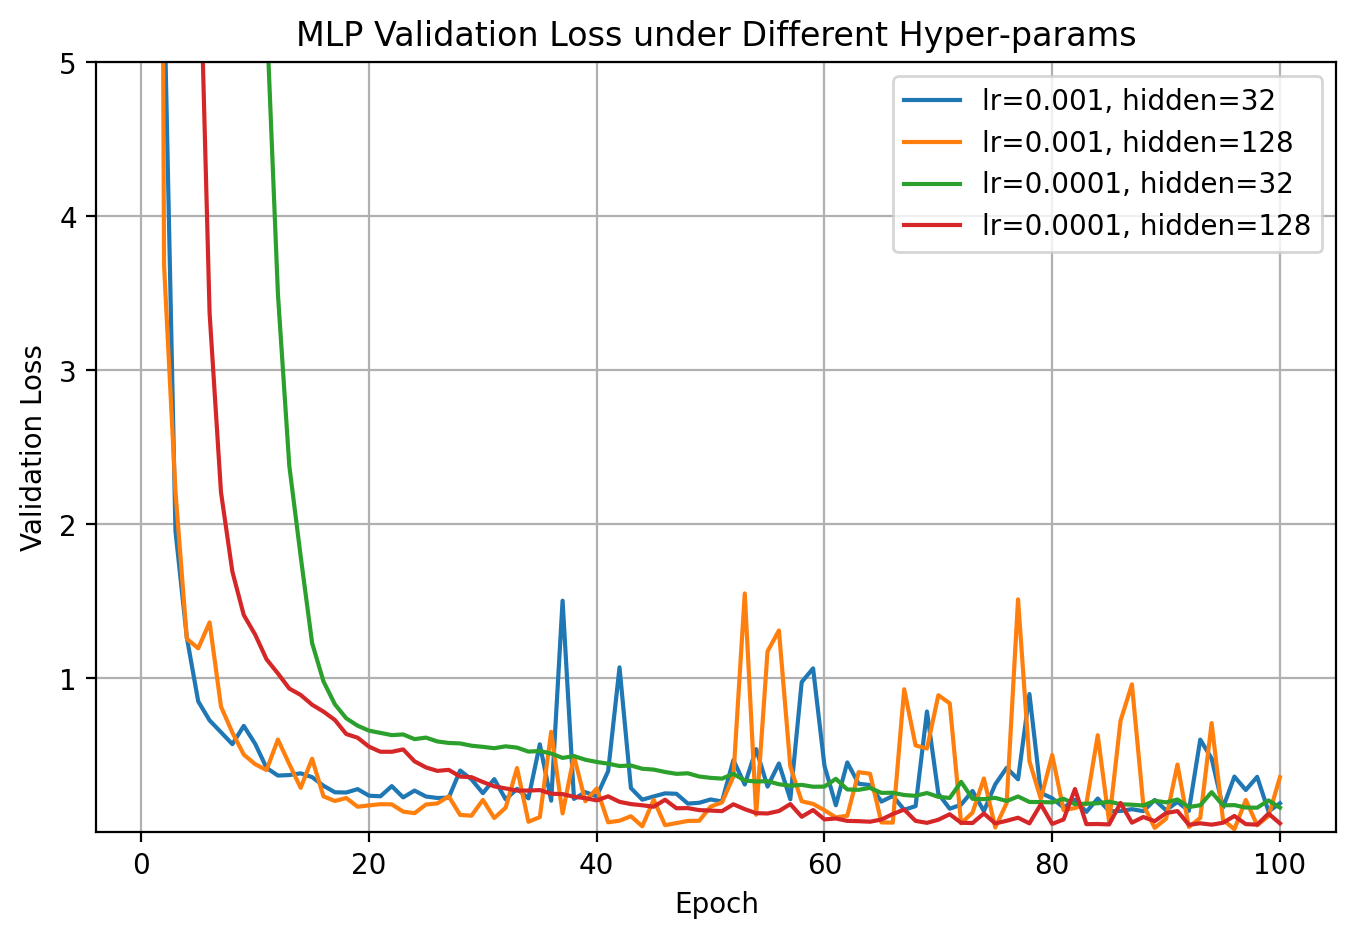


Best Valid MSE = 0.0587  (lr=0.0001, hidden=128)


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for (lr, hdim), curve in results.items():
    label = f"lr={lr}, hidden={hdim}"
    plt.plot(range(1, epochs+1), curve, label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(1e-4, 5)
plt.title("MLP Validation Loss under Different Hyper‑params")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest Valid MSE = {best_val:.4f}  (lr={best_cfg[0]}, hidden={best_cfg[1]})")

#### Observation: ####
A higher learning rate (1 × 10⁻³) converges much faster than 1 × 10⁻⁴, but its curve fluctuates more. With the smaller learning rate (1 × 10⁻⁴), training is slower, yet hidden layers = 128 helps and eventually attains the best MSE, showing that a lower lr paired with a larger hidden layer yields the lowest valid loss.

### Task 2.1: Implement the multi-head attention module (no for loops allowed, 5 points)</font>

In [21]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert input_dim % num_heads == 0

        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads

        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################

        # linear transformation layers for key, value, and query
        self.q_proj = nn.Linear(input_dim, input_dim, bias=False)
        self.k_proj = nn.Linear(input_dim, input_dim, bias=False)
        self.v_proj = nn.Linear(input_dim, input_dim, bias=False)

        # output layer
        self.out_proj = nn.Linear(input_dim, input_dim, bias=False)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]

        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        # create K, Q, V

        B, L, _ = query.size()
        Q = self.q_proj(query).view(B, L, self.num_heads, self.dim_per_head).transpose(1, 2)
        K = self.k_proj(key).view(B, L, self.num_heads, self.dim_per_head).transpose(1, 2) 
        V = self.v_proj(value).view(B, L, self.num_heads, self.dim_per_head).transpose(1, 2)   

        dk = self.dim_per_head
        dot_prod_scores = torch.matmul(Q, K.transpose(2, 3)) / dk**0.5



        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        atten = torch.softmax(dot_prod_scores, dim=-1)         
        out  = torch.matmul(atten, V)                           

        out = out.transpose(1, 2).contiguous().view(B, L, self.input_dim)
        out = self.out_proj(out)                               

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return out

In [22]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 2.2: Implement a Feedforward Network (5 points)</font>

In [24]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()

        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        self.fc1  = nn.Linear(input_dim, ff_dim)
        self.relu  = nn.ReLU()
        self.fc2  = nn.Linear(ff_dim, input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        y = self.fc2(self.relu(self.fc1(x)))   


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return x


In [25]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 2.3: Implement a Single Transformer Encoder Cell (5 points)</font>

In [27]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        ###########################################################################
        # TODO: A single Transformer encoder cell consists of
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm

        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        self.mulhead = MultiHeadAttention(input_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(input_dim)

        self.feedforward = FeedForwardNetwork(input_dim, ff_dim)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        Returns:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################
        self_attention = self.mulhead(x, x, x, mask)
        x_attention = self.norm1(x + self.dropout1(self_attention))

        feedforward_out = self.feedforward(x_attention)
        y = self.norm2(x_attention + self.dropout2(feedforward_out))
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y

In [28]:
# Let's run a sanity check of your model
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 2.4: Implement Transformer Encoder (5 points)</font>

In [30]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()

        self.norm = None
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList

        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        self.layers = nn.ModuleList([
            TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)
        ])
        self.norm = nn.LayerNorm(input_dim)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        y = x
        for layer in self.layers:
            y = layer(y, mask)       
        y = self.norm(y)              


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [31]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 2.5: Implement Positional Encoding (2 points)</font>

In [33]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim

    def forward(self, x):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel}) \\                        #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################
        device = x.device
        pos = torch.arange(seq_len, dtype=torch.float32, device=device).unsqueeze(1)
        i = torch.arange(0, input_dim, 2, dtype=torch.float32, device=device)      
        divide = torch.exp(-math.log(10000) * i / input_dim)  
        # angle = pos / torch.pow(10000, 2 * i / input_dim) # pos / 10000^{2i / dmodel}                                                                

        pe = torch.zeros(1, seq_len, input_dim, device=device)                  
        pe[..., 0::2] = torch.sin(pos * divide)  # even
        pe[..., 1::2] = torch.cos(pos * divide)  # odd


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        x = x + pe.to(x.device)
        return x

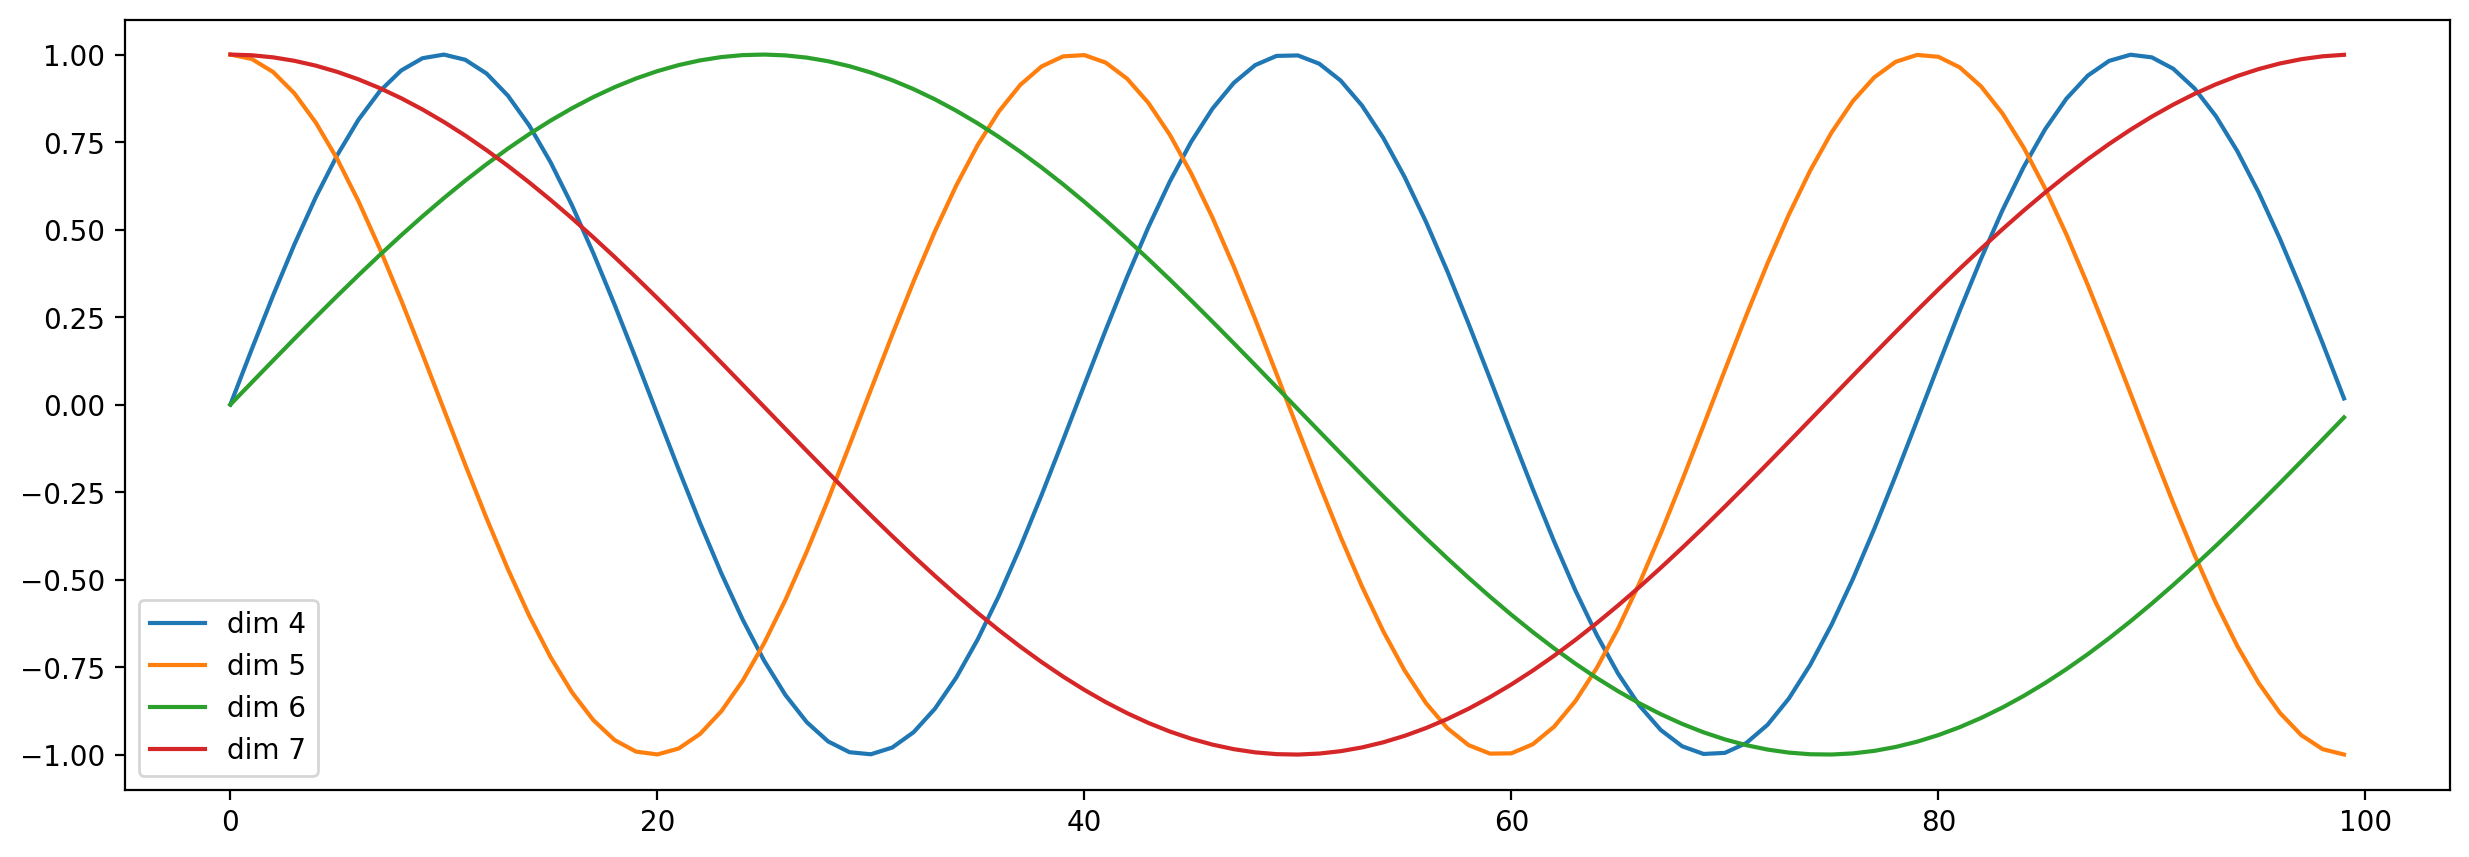

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### <font size='4' color='orange'>Task 2.6: Implement a Transformer-based predictor (3 points)</font>

In [36]:
class TransformerModel(nn.Module):
    """
    A Transformer-based predictor.
    """
    def __init__(self,
           input_dim: int, num_heads:int, trx_ff_dim: int, num_trx_cells:int, output_dim: int, dropout: float=0.1
        ):
        """
        Inputs:
        - input_dim: input_dimension of the sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - output_dim: output dimension
        - dropout: Dropout ratio
        """
        super(TransformerModel, self).__init__()

        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # a output layer                                                          #
        ###########################################################################
        self.pos_encoding = PositionalEncoding(input_dim)
        self.encoder = TransformerEncoder(input_dim, num_heads,
                                          trx_ff_dim, num_trx_cells,
                                          dropout)
        self.output = nn.Linear(input_dim, output_dim)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x, mask=None):
        """
        Inputs:
        - x: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor with the shape of BxK, where K is the output dimension
        """


        y = None
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the prediction value are computed based on the pooled features.  #
        ###########################################################################
        x_pe = self.pos_encoding(x)                 
        encoded = self.encoder(x_pe, mask)       

        pooled = encoded.mean(dim=1)            
        y = self.output(pooled)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y

In [37]:
# Let's run a sanity check of your model
batch_size, input_dim, output_dim, sequence_l = 2, 6, 3, 10
num_heads = 3
trx_ff_dim = 16
num_trx_cells = 2

x = torch.randn(batch_size, sequence_l, input_dim)
mask = None
model = TransformerModel(input_dim=input_dim, num_heads=num_heads, trx_ff_dim=trx_ff_dim, num_trx_cells=num_trx_cells, output_dim=output_dim)
print('x: {}'.format(x.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == output_dim
print(y.shape)

x: torch.Size([2, 10, 6])
torch.Size([2, 3])


### Task 2.6: Conduct experiments here (5 points)

In [39]:
# Hyper parameters
batch_size = 64 # batch size for training
epochs = 100 # epoch
lr = 1e-3 # learning rate
num_heads = 3
num_trx_cells = 2
input_dim = 6
output_dim = 2
trx_ff_dim = 128

model, loss_func = None, None
###########################################################################
# TODO: Deinfe the classifier and loss function.
###########################################################################
model = TransformerModel(input_dim, num_heads, trx_ff_dim, num_trx_cells, output_dim)
loss_func = torch.nn.MSELoss()
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################


model = model.to(device)
total_mse = None
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)

X, y = createSamples(data, lookBack=24, normalize=True)
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_mse_lst = []
val_mse_lst = []
for epoch in range(1, epochs + 1, 1):
    epoch_start_time = time.time()
    mse_train = train(model, optimizer, train_dataloader, loss_func, device)
    mse_val = evaluate(model, valid_dataloader, loss_func, device, normalize=True)
    train_mse_lst += [mse_train]
    val_mse_lst += [mse_val]
    if total_mse is not None and total_mse > mse_val:
        scheduler.step()
    else:
        total_mse = mse_val
    
    print('-' * 59)
    print('| end of epoch {:3d}  | '
          'valid mse {:8.3f} '.format(epoch, mse_val))

-----------------------------------------------------------
| end of epoch   1  | valid mse  516.195 
-----------------------------------------------------------
| end of epoch   2  | valid mse  435.710 
-----------------------------------------------------------
| end of epoch   3  | valid mse  366.817 
-----------------------------------------------------------
| end of epoch   4  | valid mse  304.196 
-----------------------------------------------------------
| end of epoch   5  | valid mse  244.904 
-----------------------------------------------------------
| end of epoch   6  | valid mse  189.858 
-----------------------------------------------------------
| end of epoch   7  | valid mse  141.487 
-----------------------------------------------------------
| end of epoch   8  | valid mse  106.467 
-----------------------------------------------------------
| end of epoch   9  | valid mse   76.065 
-----------------------------------------------------------
| end of epoch  10  | 

In [40]:
lrs = [1e-3, 1e-4]
ff_dims = [32, 128]

results = {}
best_val = float("inf")
best_cfg = None
for lr in lrs:
    for ff_dim in ff_dims:
        print(f"\nTraining Transformer with learning rates={lr}, hidden layer sizes={ff_dim}:")
        # Initialized model and loss function (MSE Loss)
        model = TransformerModel(input_dim, num_heads, ff_dim, num_trx_cells, output_dim).to(device)
        loss_func = torch.nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)

        val_curve = []
        # Training loop (unchanged)
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            _ = train(model, optimizer, train_dataloader, loss_func, device)
            mse_val = evaluate(model, valid_dataloader, loss_func, device, normalize=True)
            val_curve.append(mse_val)
            
            if epoch % 20 == 0 or epoch == 1:
                print('-' * 59)
                print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s | valid mse {mse_val:8.3f} ')
        
        results[(lr, ff_dim)] = val_curve
        if val_curve[-1] < best_val:
            best_val = val_curve[-1]
            best_cfg = (lr, ff_dim)


Training Transformer with learning rates=0.001, hidden layer sizes=32:
-----------------------------------------------------------
| end of epoch   1 | time:  0.55s | valid mse  347.542 
-----------------------------------------------------------
| end of epoch  20 | time:  0.55s | valid mse   18.830 
-----------------------------------------------------------
| end of epoch  40 | time:  0.57s | valid mse    4.992 
-----------------------------------------------------------
| end of epoch  60 | time:  0.54s | valid mse    1.211 
-----------------------------------------------------------
| end of epoch  80 | time:  0.53s | valid mse    1.783 
-----------------------------------------------------------
| end of epoch 100 | time:  0.57s | valid mse    0.683 

Training Transformer with learning rates=0.001, hidden layer sizes=128:
-----------------------------------------------------------
| end of epoch   1 | time:  0.51s | valid mse  307.487 
-------------------------------------------

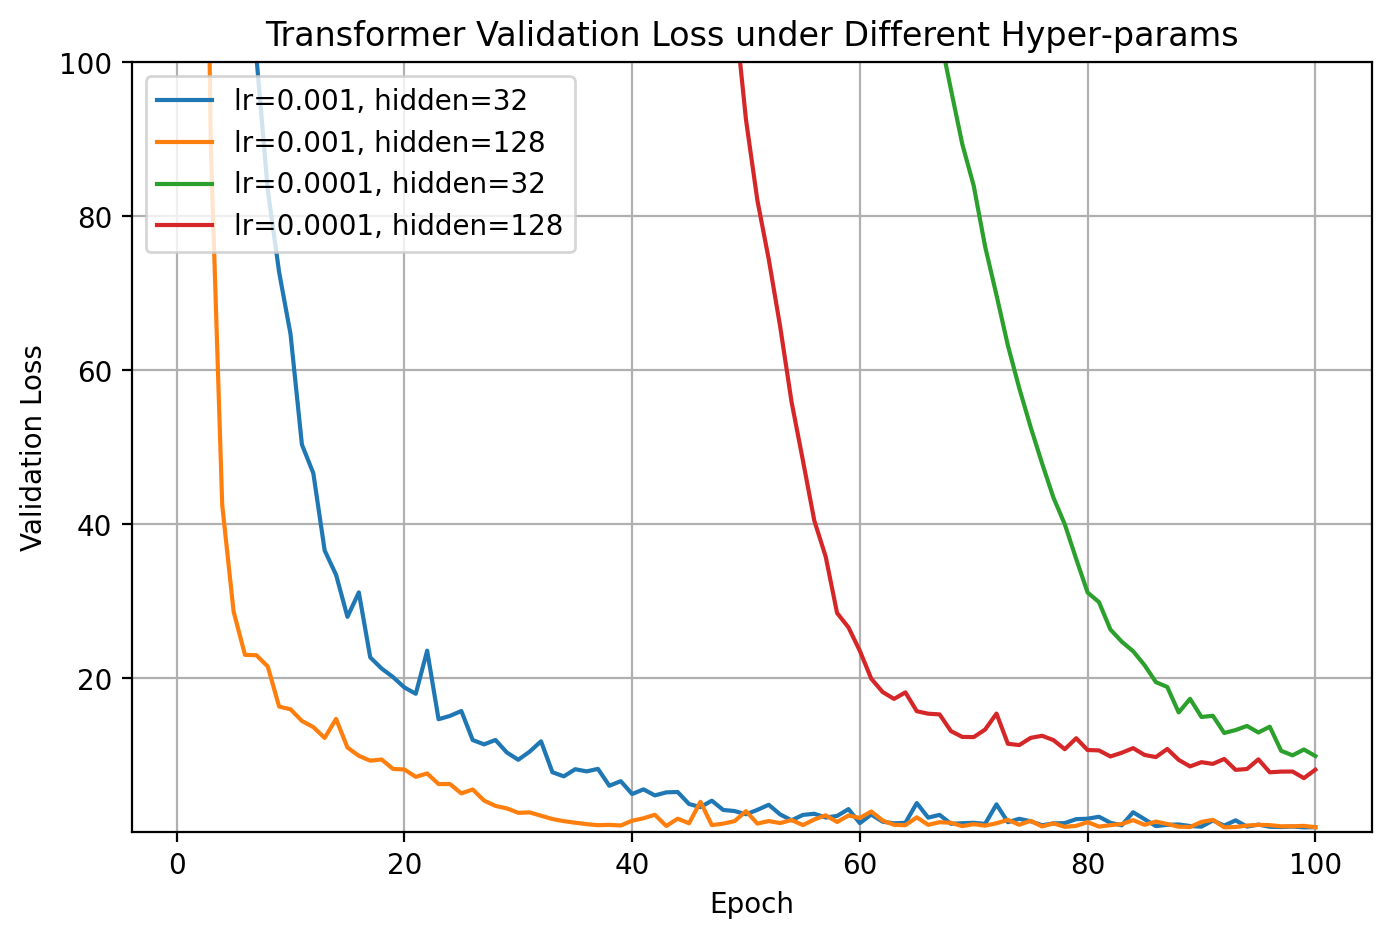


Best Valid MSE = 0.6833  (lr=0.001, hidden=32)


In [41]:
plt.figure(figsize=(8,5))
for (lr, hdim), curve in results.items():
    label = f"lr={lr}, hidden={hdim}"
    plt.plot(range(1, epochs+1), curve, label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(1e-4, 100)
plt.title("Transformer Validation Loss under Different Hyper‑params")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest Valid MSE = {best_val:.4f}  (lr={best_cfg[0]}, hidden={best_cfg[1]})")

### Observation: ###
A higher learning rate (1 × 10⁻³) again accelerates convergence. With lr = 1 × 10⁻³, hidden layers = 32 and 128 shows similar validation MSE performance while Valid MSE of hidden = 32 is slightly lower. The smaller learning‑rate runs plateau higher and even cannot converge in 100 epochs.

### Discussion: ###
#### Key Differences: #### 
Transformers use self-attention to capture long-range dependencies across time steps, while MLPs treat each time step independently after flattening.
#### Preferences: ####
Transformers generally perform better on complex or long time-series, especially with variable dependencies. MLPs are simpler, faster, and suffice for short sequences or low-complexity patterns.